In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tensorflow.keras import models, layers, regularizers

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


In [3]:
data_train = np.load('Datasets/Wood_train.npy', allow_pickle= True)
data_test = np.load('Datasets/Wood_test.npy', allow_pickle= True)

train_labels = np.load('Datasets/Wood_train_labels.npy', allow_pickle= True)
test_labels = np.load('Datasets/Wood_test_labels.npy', allow_pickle= True)

data_train.shape, train_labels.shape, data_test.shape, test_labels.shape

((264, 32, 32, 320), (264,), (132, 32, 32, 320), (132,))

In [4]:
mean = data_train.mean(axis=(0, 1, 2), keepdims=True)
std_dev = data_train.std(axis=(0, 1, 2), keepdims=True)

# Z-score normalization
data_train = (data_train - mean) / std_dev

data_test = (data_test - mean) / std_dev

print("Train Shape:", data_train.shape)
print("Test Shape:", data_test.shape)

Train Shape: (264, 32, 32, 320)
Test Shape: (132, 32, 32, 320)


In [5]:
# Add channel dimension to data
data_train = data_train[..., np.newaxis]
data_test = data_test[..., np.newaxis]

data_train.shape, data_test.shape

((264, 32, 32, 320, 1), (132, 32, 32, 320, 1))

In [6]:
le= LabelEncoder()
y_train = le.fit_transform(train_labels)

le2= LabelEncoder()
y_test= le2.fit_transform(test_labels)

In [7]:
def augment_data(sample, label):
    
    # Random flip along different axes
    sample = tf.image.random_flip_left_right(sample)
    sample = tf.image.random_flip_up_down(sample)

    # Random rotation
    sample = tf.image.rot90(sample, k=np.random.randint(1, 4))  # k=1 to 3 random rotations of 90°

    # Random intensity scaling (brightness variation)
    sample = sample * tf.random.uniform([], 0.9, 1.1)  # Random scale between 0.9 and 1.1
    
    return sample, label

In [8]:
# Convert data to TensorFlow dataset

train_dataset = tf.data.Dataset.from_tensor_slices((data_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((data_test, y_test))

#Augmentation
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch
batch_size = 8

train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
tf.random.set_seed(1234)

input_shape = (32, 32, 320, 1)

model = models.Sequential([
    layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu', input_shape=input_shape),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu'),
    layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.summary()
'''

input_shape = (32, 32, 320, 1)

model = models.Sequential([
    
    layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
    layers.BatchNormalization(),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    #layers.Dropout(0.3),  # Dropout with a rate of 0.3


    layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    
    
    layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    #layers.Dropout(0.3),  # Dropout with a rate of 0.3

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with a rate of 0.5
    
    #layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.summary()
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 30, 318, 32)   896       
                                                                 
 average_pooling3d (AverageP  (None, 15, 15, 159, 32)  0         
 ooling3D)                                                       
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 13, 157, 64)   55360     
                                                                 
 conv3d_2 (Conv3D)           (None, 11, 11, 155, 128)  221312    
                                                                 
 average_pooling3d_1 (Averag  (None, 5, 5, 77, 128)    0         
 ePooling3D)                                                     
                                                                 
 flatten (Flatten)           (None, 246400)            0

"\n\ninput_shape = (32, 32, 320, 1)\n\nmodel = models.Sequential([\n    \n    layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',\n                  kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),\n    layers.BatchNormalization(),\n    layers.AveragePooling3D(pool_size=(2, 2, 2)),\n    \n    #layers.Dropout(0.3),  # Dropout with a rate of 0.3\n\n\n    layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',\n                  kernel_regularizer=regularizers.l2(0.001)),\n    layers.BatchNormalization(),\n    \n    \n    layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',\n                  kernel_regularizer=regularizers.l2(0.0001)),\n    layers.BatchNormalization(),\n    layers.AveragePooling3D(pool_size=(2, 2, 2)),\n    \n    #layers.Dropout(0.3),  # Dropout with a rate of 0.3\n\n    layers.Flatten(),\n\n    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),\n

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

'''
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor = 'loss',
                            patience = 5,
                            restore_best_weights = True
                        )
                    ])

'''
# Define the callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'best_model_3.h5',   
    monitor = 'val_accuracy',  
    save_best_only = True,       
    save_weights_only = False,  
    mode = 'max',
    verbose = 1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss',
    patience = 15,
    restore_best_weights = True
)

# Train the model with the callbacks
history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = test_dataset,
    callbacks = [checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 7.6424 - accuracy: 0.6591
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_3.h5
33/33 [==============================] - 18s 246ms/step - loss: 7.6424 - accuracy: 0.6591 - val_loss: 0.8051 - val_accuracy: 0.5000
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.2424
Epoch 2: val_accuracy did not improve from 0.50000
33/33 [==============================] - 7s 216ms/step - loss: 0.7793 - accuracy: 0.2424 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.3182
Epoch 3: val_accuracy did not improve from 0.50000
33/33 [==============================] - 7s 215ms/step - loss: 0.6943 - accuracy: 0.3182 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.3258
Epoch 4: val_accuracy did not improve f

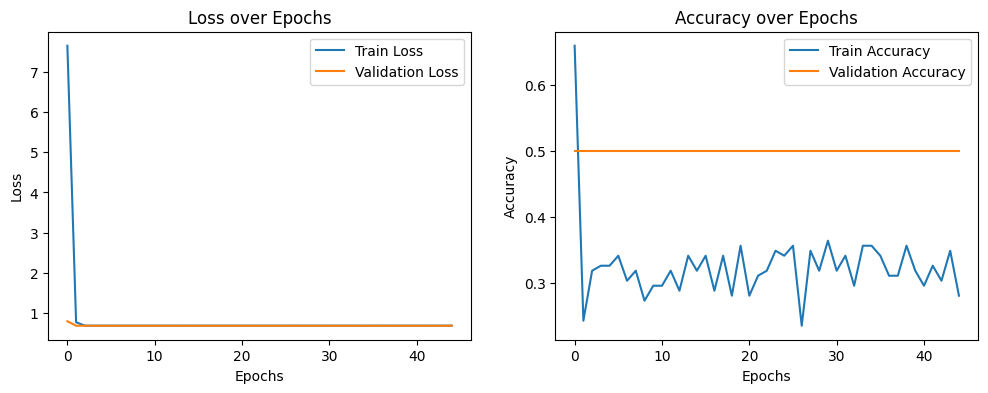

In [11]:
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
# Get true labels and predictions
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = np.argmax(model.predict(test_dataset), axis=-1)

17/17 [==============================] - 1s 56ms/step


In [13]:
# Classification report
print("Classification Report:")
print(classification_report(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.50      1.00      0.67        66

    accuracy                           0.50       132
   macro avg       0.25      0.50      0.33       132
weighted avg       0.25      0.50      0.33       132



c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

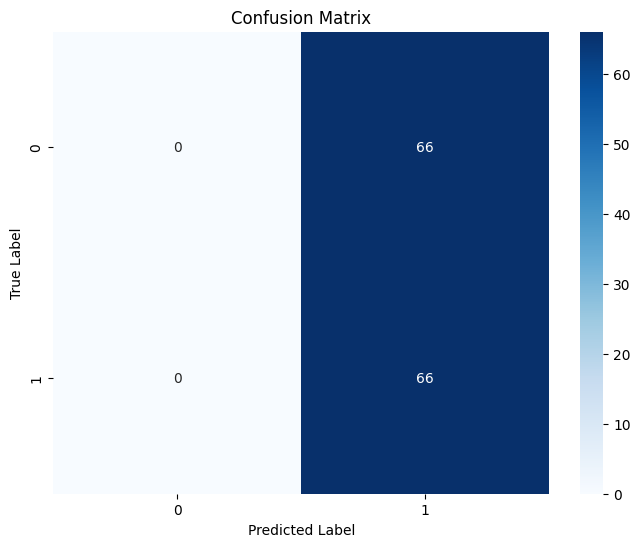

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(2)], yticklabels=[str(i) for i in range(2)])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()